<a href="https://colab.research.google.com/github/Zfeng0207/FIT3199-FYP/blob/dev%2Fzfeng/lstm_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main')

TPU has a different way of downloading dependencies keep the cell below to avoid dependency conflicts

In [3]:
!pip install --user -qqqq mlflow wfdb resampy

In [4]:
import sys
import os

user_lib_path = os.path.expanduser("~/.local/lib/python3.11/site-packages")
if user_lib_path not in sys.path:
    sys.path.append(user_lib_path)

In [5]:
import mlflow
import wfdb
import resampy

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

import argparse
import pandas as pd
import numpy as np
from pathlib import Path
import wfdb
from tqdm.auto import tqdm
from extract_headers import extract_and_open_files_in_zip

In [7]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src')

# from icdmappings import Mapper
from ecg_utils import prepare_mimicecg
from mimic_ecg_preprocessing import prepare_mimic_ecg

In [8]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main/src/utils')

# from timeseries_utils import reformat_as_memmap
from stratify import stratified_subsets

In [9]:
memmap_meta_path = "src/data/memmap_meta.npz"
memmap_path = "src/data/memmap/memmap.npy"
df_mapped_path = "src/data/records_w_stroke_labels.csv"
df_pkl_path = "src/data/processed/df.pkl"

In [11]:
df_pkl = pd.read_pickle(df_pkl_path)
df_mapped = pd.read_csv(df_mapped_path)  # Assuming df_mapped is saved as a pickle

merged_df = pd.merge(df_pkl, df_mapped, on=["study_id"], how="left")

# Inspect the merged DataFrame
print("Merged DataFrame Columns:", merged_df.columns)
print("Merged DataFrame Shape:", merged_df.shape)

# Example: Select relevant columns for training
# Input features: ECG signal reference and metadata
# Target labels: Diagnostic labels

# Transform the 'label_strat_all2all' column
merged_df['Stroke_YN'] = merged_df['label_strat_all2all'].apply(lambda x: 0 if x == "['outpatient']" else 1)

# Verify the transformation
print(merged_df[['label_strat_all2all', 'Stroke_YN']].head())

Merged DataFrame Columns: Index(['data', 'study_id', 'subject_id', 'ecg_time_x', 'nans', 'data_mean',
       'data_std', 'data_length', 'filename', 'patient_id', 'ecg_time_y',
       'hosp_diag_hosp', 'hosp_hadm_id', 'ed_diag_ed', 'ed_diag_hosp',
       'ed_stay_id', 'ed_hadm_id', 'all_diag_hosp', 'all_diag_all', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'age',
       'ecg_no_within_stay', 'ecg_taken_in_ed', 'ecg_taken_in_hosp',
       'ecg_taken_in_ed_or_hosp', 'fold', 'label_strat_all2all', 'label_test',
       'has_statements_train', 'has_statements_test', 'age_bin',
       'merged_strat'],
      dtype='object')
Merged DataFrame Shape: (21649, 36)
  label_strat_all2all  Stroke_YN
0      ['outpatient']          0
1      ['outpatient']          0
2      ['outpatient']          0
3      ['outpatient']          0
4      ['outpatient']          0


<ipython-input-13-86ee3fd71fa9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


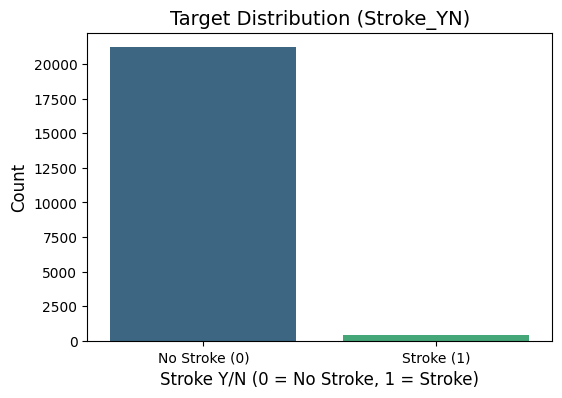

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each target class
target_counts = merged_df['Stroke_YN'].value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")
plt.title("Target Distribution (Stroke_YN)", fontsize=14)
plt.xlabel("Stroke Y/N (0 = No Stroke, 1 = Stroke)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], labels=["No Stroke (0)", "Stroke (1)"])
plt.show()

In [ ]:
# merged_df.to_csv("/Users/zfeng/Documents/ECG-MIMIC/ECG-MIMIC/preprocessed_data/merged_df.csv", index=False)

In [15]:
import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

os.environ['MLFLOW_TRACKING_USERNAME'] = "Zfeng0207"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "af7c8365aec4d3ff7a40563a35ec94d4bc9b4512"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "stroke-prediction-dagshub-repo"

experiment_name = "ecg-lstm-experiment"
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')
mlflow.set_experiment(experiment_name)

print(f"MLflow tracking experiment name: {experiment_name}")
print(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')


MLflow tracking experiment name: ecg-lstm-experiment
https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow


# Data Class

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class ECGDataset(Dataset):
    def __init__(self, df, memmap_file, memmap_meta_file):
        # Load memory-mapped ECG data
        self.ecg_data = np.fromfile(memmap_file, dtype=np.float32)

        # Load metadata
        memmap_meta = np.load(memmap_meta_file, allow_pickle=True)
        self.starts = memmap_meta["start"].astype(int)
        self.lengths = memmap_meta["length"].astype(int)
        self.original_shape = tuple(memmap_meta["shape"])
        self.ecg_data = self.ecg_data.reshape(self.original_shape)

        # Use the provided DataFrame (train or test)
        self.df = df.reset_index(drop=True)

        # Filter metadata to match the DataFrame
        self.starts = self.starts[self.df.index]
        self.lengths = self.lengths[self.df.index]

        # Filter out invalid samples
        self.valid_indices = self.filter_invalid_samples()

    def filter_invalid_samples(self):
        valid_indices = []
        for idx in range(len(self.df)):
            start_idx = self.starts[idx]
            length = self.lengths[idx]

            if start_idx < 0 or start_idx + length > len(self.ecg_data):
                continue

            # Extract ECG signal
            ecg_signal = self.ecg_data[start_idx : start_idx + length, :]

            # Check for NaN or Inf values
            if not np.isnan(ecg_signal).any() and not np.isinf(ecg_signal).any():
                valid_indices.append(idx)
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map valid index to original index
        original_idx = self.valid_indices[idx]
        row = self.df.iloc[original_idx]

        start_idx = self.starts[original_idx]
        length = self.lengths[original_idx]

        # Extract ECG signal
        ecg_signal = self.ecg_data[start_idx : start_idx + length, :]

        # Normalize the ECG signal
        ecg_signal = (ecg_signal - np.mean(ecg_signal)) / (np.std(ecg_signal) + 1e-8)

        label = row["Stroke_YN"]

        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)

        return ecg_signal, label

# Simple LSTM Model

In [17]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        return out  # No sigmoid here

In [18]:
# Collate function for padding
def collate_fn(batch):
    ecg_signals, labels = zip(*batch)
    ecg_signals = pad_sequence(ecg_signals, batch_first=True)  # Pad sequences
    labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    return ecg_signals, labels

In [19]:
from tqdm.auto import tqdm

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    device = torch.device("cuda")

    with torch.no_grad():
        for ecg_signals, labels in tqdm(dataloader, desc="Evaluating", leave=False):
          if torch.cuda.is_available():
            ecg_signals = ecg_signals.to(device)
            labels = labels.to(device)
          outputs = model(ecg_signals)
          probs = torch.sigmoid(outputs).squeeze(1)
          preds = (probs >= 0.5).int()
          all_preds.extend(preds.tolist())
          all_labels.extend(labels.squeeze().tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float("nan")  # AUC requires both classes to be present

    return acc, f1, auc


# Model Training

In [20]:
import mlflow
import mlflow.pytorch
from sklearn.utils.class_weight import compute_class_weight

def train_model(train_df, val_df, memmap_file, memmap_meta_file, num_epochs=10):
    train_dataset = ECGDataset(train_df, memmap_file, memmap_meta_file)
    val_dataset = ECGDataset(val_df, memmap_file, memmap_meta_file)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

    hidden_size = 64
    num_layers = 2
    batch_size = 32
    lr = 0.001

    device = torch.device("cuda")

    model = SimpleLSTM(input_size=12, hidden_size=hidden_size, num_layers=num_layers, output_size=1)
    model = model.to(device)

    class_labels = train_df['Stroke_YN'].unique()
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['Stroke_YN'])
    class_weights_dict = dict(zip(class_labels, class_weights))

    pos_weight = class_weights_dict[1]

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, dtype=torch.float32, device=device))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    with mlflow.start_run():
        # Log hyperparameters
        mlflow.log_param("hidden_size", hidden_size)
        mlflow.log_param("num_layers", num_layers)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("epochs", num_epochs)

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            for ecg_signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):

                if torch.cuda.is_available():
                  ecg_signals = ecg_signals.to(device)
                  labels = labels.to(device)

                outputs = model(ecg_signals)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item()

            val_acc, val_f1, val_auc = evaluate_model(model, val_loader)

            # Log metrics for each epoch
            mlflow.log_metric("train_loss", epoch_loss / len(train_loader), step=epoch)
            mlflow.log_metric("val_accuracy", val_acc, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)
            mlflow.log_metric("val_auc", val_auc, step=epoch)

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, "
                  f"Val Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

        # Save model artifact
        model_path = "src/model/simple_lstm_model.pth" #parent doesnt exist
        # torch.save(model.state_dict(), model_path)
        # mlflow.log_artifact(model_path)
        # mlflow.pytorch.log_model(model, artifact_path="lstm_model")

        print("✅ Model tracked with MLflow")

    return model


In [21]:
!pwd

/content/drive/MyDrive/Colab Notebooks/ECG-MIMIC-main


In [22]:
def test_model(model, test_df, memmap_file, memmap_meta_file):
    test_dataset = ECGDataset(test_df, memmap_file, memmap_meta_file)
    test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

    acc, f1, auc = evaluate_model(model, test_loader)
    print(f"\n📊 Test Results — Accuracy: {acc:.4f}, F1 Score: {f1:.4f}, AUC-ROC: {auc:.4f}")

    # Optionally log test metrics
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_f1", f1)
    mlflow.log_metric("test_auc", auc)


In [27]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(merged_df, test_size=0.2, stratify=merged_df["Stroke_YN"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["Stroke_YN"], random_state=42)

# Train and test
model = train_model(train_df, val_df, memmap_path, memmap_meta_path, num_epochs=10)
test_model(model, test_df, memmap_path, memmap_meta_path)

Epoch 1/10:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.9860, Val Acc: 0.9801, F1: 0.0000, AUC: 0.5000


Epoch 2/10:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.9626, Val Acc: 0.9801, F1: 0.0000, AUC: 0.5000


Epoch 3/10:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.9574, Val Acc: 0.9801, F1: 0.0000, AUC: 0.5000


Epoch 4/10:   0%|          | 0/540 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.9549, Val Acc: 0.9801, F1: 0.0000, AUC: 0.5000


Epoch 5/10:   0%|          | 0/540 [00:00<?, ?it/s]

🏃 View run languid-asp-666 at: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow/#/experiments/0/runs/6a375b35781c436fa856f0821272ff1b
🧪 View experiment at: https://dagshub.com/Zfeng0207/stroke-prediction-dagshub-repo.mlflow/#/experiments/0


KeyboardInterrupt: 

In [ ]:
print(memmap_meta_path)
print(memmap_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the raw data
data = np.fromfile("/Users/zfeng/Documents/ECG-MIMIC/ECG-MIMIC/data/memmap/memmap.npy", dtype=np.float32)
print("Raw data size:", data.size)

# Load the metadata
meta = np.load("/Users/zfeng/Documents/ECG-MIMIC/ECG-MIMIC/data/memmap_meta.npz", allow_pickle=True)
starts = meta["start"]
lengths = meta["length"]
original_shape = tuple(meta["shape"])
print(f"Original shape from metadata: {original_shape}")
print(f"Number of individual recordings: {len(starts)}")

# Reshape data according to metadata
ecg_data = data.reshape(original_shape)
print(f"Reshaped ECG data: {ecg_data.shape}")

# Function to visualize a 12-lead ECG
def visualize_12lead_ecg(ecg_data, patient_index=0):
    # Get the start and length for this patient
    start_idx = starts[patient_index]
    length = lengths[patient_index]

    # Extract the data for this patient - all 12 leads
    patient_data = ecg_data[start_idx:start_idx+length, :]

    # Standard 12-lead ECG lead names
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Create a figure with 12 subplots (3x4 grid)
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    axes = axes.flatten()

    # Plot each lead
    for i, ax in enumerate(axes):
        if i < 12:  # We have 12 leads
            ax.plot(patient_data[:, i])
            ax.set_title(f'Lead {lead_names[i]}')
            ax.grid(True, alpha=0.3)

            # Add a small vertical scale bar (1 mV)
            # This is an approximation - normally would need calibration
            y_range = np.max(patient_data[:, i]) - np.min(patient_data[:, i])
            scale_bar = y_range * 0.2  # 20% of the range as a scale reference
            ax.plot([10, 10], [np.min(patient_data[:, i]), np.min(patient_data[:, i]) + scale_bar],
                   'k-', linewidth=2)

            # Remove tick labels to mimic clinical ECG appearance
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')  # Hide unused subplot

    # Add a title for the entire plot
    plt.suptitle(f'12-Lead ECG - Patient #{patient_index+1}', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Adjust to make room for suptitle

    return fig

# Visualize ECGs for first 3 patients
for i in range(3):
    fig = visualize_12lead_ecg(ecg_data, i)
    plt.figure(fig.number)
    plt.savefig(f'patient_{i+1}_12lead_ecg.png', dpi=300, bbox_inches='tight')
    plt.show()

# Basic statistics
print("\nStatistics for all ECG data:")
print("Min value:", ecg_data.min())
print("Max value:", ecg_data.max())
print("Mean:", ecg_data.mean())
print("Standard deviation:", ecg_data.std())